In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
from sklearn import preprocessing
from collections import deque
import random
import numpy as np

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM

# Exploratory Data Analysis

In [6]:
Dataset = pd.read_csv('/content/uq_vsd_case01_fulldata_13 - (Modified).csv')
Dataset.head()

,Time,RelativeTimeMilliseconds,Clock,HR,ST-II,Pulse,SpO2,Perf,etCO2,imCO2,awRR,NBP (Sys),NBP (Dia),NBP (Mean),NBP (Pulse),NBP (Time Remaining),ART (Sys),ART (Dia),ART (Mean),etDES,inDES,etISO,inISO,etSEV,inSEV,etN2O,inN2O,MAC,etO2,inO2,Temp,BIS,SQI,EMG,Tidal Volume,Minute Volume,RR,Set Tidal Volume,Set RR,Set I:E Ratio,Set PEEP,Set PAWmax,Set PAWmin,Set Mechanical Ventilation,Tidal Volume Exp (Spiro),Tidal Volume In (Spiro),Minute Volume Exp (Spiro),Minute Volume In (Spiro),Lung Compliance (Spiro),Airway Resistance (Spiro),Max Inspiratory Pressure (Spiro),ECG,Pleth,CO2,ART,EEG,AWP,AWF,AWV,AWP-Spiro,AWF-Spiro,AWV-Spiro,Num Patient Alarms,Num Technical Alarms
0,02:00:00_000,7200000,19:33,51.0,NaN,51,98,3.0,39,1,7,94,50.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8,0.45,0,0,0.4,88,95,NaN,NaN,NaN,NaN,882,6.1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.160,0.39512,36.8,NaN,NaN,8.20354,43.02551,630.2,NaN,NaN,NaN,0,0
1,02:00:00_010,7200010,19:33,51.0,NaN,51,98,3.0,39,1,7,94,50.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8,0.45,0,0,0.4,88,95,NaN,NaN,NaN,NaN,882,6.1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.155,0.39243,36.8,NaN,NaN,8.18365,43.15805,637.4,NaN,NaN,NaN,0,0
2,02:00:00_020,7200020,19:33,51.0,NaN,51,98,3.0,39,1,7,94,50.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8,0.45,0,0,0.4,88,95,NaN,NaN,NaN,NaN,882,6.1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.150,0.39170,36.8,NaN,NaN,8.16036,42.97751,644.6,NaN,NaN,NaN,0,0
3,02:00:00_030,7200030,19:33,51.0,NaN,51,98,3.0,39,1,7,94,50.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8,0.45,0,0,0.4,88,95,NaN,NaN,NaN,NaN,882,6.1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.145,0.39145,36.8,NaN,NaN,8.16700,42.43487,651.6,NaN,NaN,NaN,0,0
4,02:00:00_040,7200040,19:33,51.0,NaN,51,98,3.0,39,1,7,94,50.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8,0.45,0,0,0.4,88,95,NaN,NaN,NaN,NaN,882,6.1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.140,0.39243,36.8,NaN,NaN,8.13787,42.65852,658.7,NaN,NaN,NaN,0,0


In [7]:
Dataset.columns

Index(['Time', 'RelativeTimeMilliseconds', 'Clock', 'HR', 'ST-II', 'Pulse',
       'SpO2', 'Perf', 'etCO2', 'imCO2', 'awRR', 'NBP (Sys)', 'NBP (Dia)',
       'NBP (Mean)', 'NBP (Pulse)', 'NBP (Time Remaining)', 'ART (Sys)',
       'ART (Dia)', 'ART (Mean)', 'etDES', 'inDES', 'etISO', 'inISO', 'etSEV',
       'inSEV', 'etN2O', 'inN2O', 'MAC', 'etO2', 'inO2', 'Temp', 'BIS', 'SQI',
       'EMG', 'Tidal Volume', 'Minute Volume', 'RR', 'Set Tidal Volume',
       'Set RR', 'Set I:E Ratio', 'Set PEEP', 'Set PAWmax', 'Set PAWmin',
       'Set Mechanical Ventilation', 'Tidal Volume Exp (Spiro)',
       'Tidal Volume In (Spiro)', 'Minute Volume Exp (Spiro)',
       'Minute Volume In (Spiro)', 'Lung Compliance (Spiro)',
       'Airway Resistance (Spiro)', 'Max Inspiratory Pressure (Spiro)', 'ECG',
       'Pleth', 'CO2', 'ART', 'EEG', 'AWP', 'AWF', 'AWV', 'AWP-Spiro',
       'AWF-Spiro', 'AWV-Spiro', 'Num Patient Alarms', 'Num Technical Alarms'],
      dtype='object')

In [8]:
Dataset = Dataset[['Pulse','SpO2','etCO2','NBP (Sys)','NBP (Dia)']]
Dataset.head()

,Pulse,SpO2,etCO2,NBP (Sys),NBP (Dia)
0,51,98,39,94,50.0
1,51,98,39,94,50.0
2,51,98,39,94,50.0
3,51,98,39,94,50.0
4,51,98,39,94,50.0


In [9]:
Dataset.describe()

,Pulse,SpO2,etCO2,NBP (Sys),NBP (Dia)
count,9600.000000,9600.000000,9600.000000,9600.000000,8269.000000
mean,52.205312,97.370625,38.808021,103.952812,60.948361
std,1.527889,1.354204,1.206779,4.078427,4.739704
min,50.000000,94.000000,37.000000,94.000000,50.000000
25%,51.000000,97.000000,38.000000,103.000000,63.000000
50%,52.000000,97.000000,39.000000,106.000000,63.000000
75%,53.000000,99.000000,39.000000,106.000000,63.000000
max,57.000000,100.000000,41.000000,106.000000,63.000000


In [10]:
Dataset = Dataset.dropna()
Dataset.describe()

,Pulse,SpO2,etCO2,NBP (Sys),NBP (Dia)
count,8269.000000,8269.000000,8269.000000,8269.000000,8269.000000
mean,52.213569,97.318660,38.752328,104.106180,60.948361
std,1.455302,1.186081,1.283514,4.375112,4.739704
min,50.000000,94.000000,37.000000,94.000000,50.000000
25%,51.000000,97.000000,38.000000,106.000000,63.000000
50%,52.000000,97.000000,39.000000,106.000000,63.000000
75%,53.000000,98.000000,39.000000,106.000000,63.000000
max,55.000000,100.000000,41.000000,106.000000,63.000000


In [11]:
Dataset.corr()

,Pulse,SpO2,etCO2,NBP (Sys),NBP (Dia)
Pulse,1.000000,0.027064,-0.197206,0.361005,0.361005
SpO2,0.027064,1.000000,-0.062239,-0.563617,-0.563617
etCO2,-0.197206,-0.062239,1.000000,-0.242231,-0.242231
NBP (Sys),0.361005,-0.563617,-0.242231,1.000000,1.000000
NBP (Dia),0.361005,-0.563617,-0.242231,1.000000,1.000000


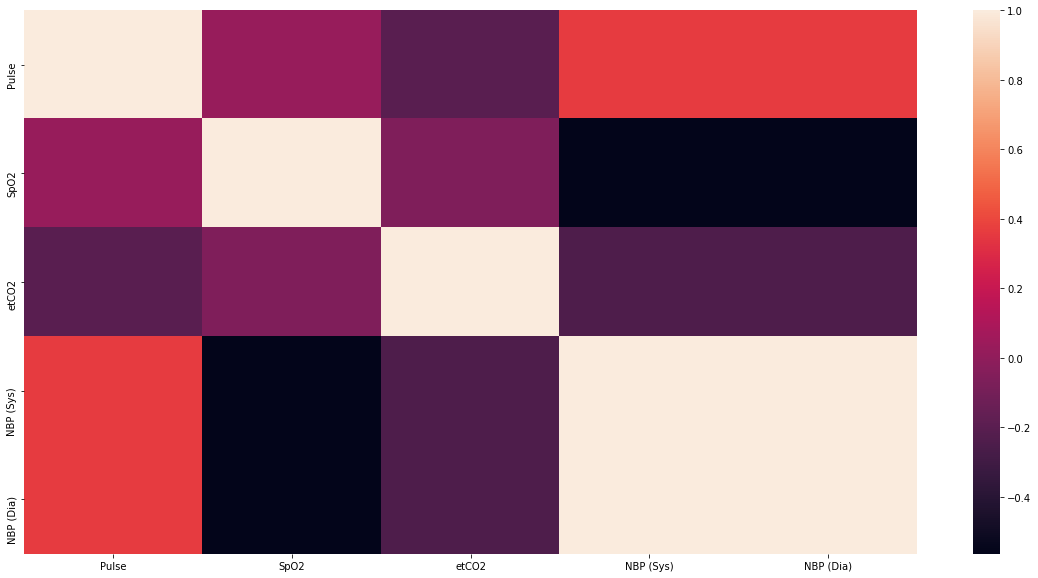

In [12]:
plt.figure(figsize=(20,10))
sns.heatmap(Dataset.corr())
plt.show()

# Inference: Only Pulse and NBP (Dia) are independent of each other 

# Preparing Data for Time Series Prediction

In [60]:
N_TIMESTAMPS = 50

In [61]:
Dataset = pd.read_csv('/content/uq_vsd_case01_fulldata_13 - (Modified).csv')
Dataset = Dataset[['Pulse','SpO2','etCO2','NBP (Sys)','NBP (Dia)']]
Dataset = Dataset.dropna()
for i in Dataset.columns:
  Dataset['Future '+i] = Dataset[i].shift(-1*N_TIMESTAMPS)
old=len(Dataset)
Dataset = Dataset.dropna()
new=len(Dataset)
print('Number of rows reduced from: ',old,' to ',new)

Number of rows reduced from:  8269  to  8219


In [62]:
Dataset.shape

(8219, 10)

In [63]:
for col in Dataset.columns:
  Dataset[col]=preprocessing.scale(Dataset[col].values)
Dataset.head()

,Pulse,SpO2,etCO2,NBP (Sys),NBP (Dia),Future Pulse,Future SpO2,Future etCO2,Future NBP (Sys),Future NBP (Dia)
0,-0.838253,0.576805,0.189034,-2.301757,-2.301757,-0.838253,0.576805,0.193584,-2.355632,-2.355632
1,-0.838253,0.576805,0.189034,-2.301757,-2.301757,-0.838253,0.576805,0.193584,-2.355632,-2.355632
2,-0.838253,0.576805,0.189034,-2.301757,-2.301757,-0.838253,0.576805,0.193584,-2.355632,-2.355632
3,-0.838253,0.576805,0.189034,-2.301757,-2.301757,-0.838253,0.576805,0.193584,-2.355632,-2.355632
4,-0.838253,0.576805,0.189034,-2.301757,-2.301757,-0.838253,0.576805,0.193584,-2.355632,-2.355632


In [64]:
Dataset.values

array([[-0.83825295,  0.57680506,  0.18903385, ...,  0.19358374,
        -2.3556324 , -2.3556324 ],
       [-0.83825295,  0.57680506,  0.18903385, ...,  0.19358374,
        -2.3556324 , -2.3556324 ],
       [-0.83825295,  0.57680506,  0.18903385, ...,  0.19358374,
        -2.3556324 , -2.3556324 ],
       ...,
       [-0.83825295,  0.57680506, -0.58857838, ..., -0.58330334,
         0.42451445,  0.42451445],
       [-0.83825295,  0.57680506, -0.58857838, ..., -0.58330334,
         0.42451445,  0.42451445],
       [-0.83825295,  0.57680506, -0.58857838, ..., -0.58330334,
         0.42451445,  0.42451445]])

In [65]:
Sequential_Data = []
previousN = deque(maxlen=N_TIMESTAMPS)
for record in Dataset.values:
  previousN.append([datavalue for datavalue in record[:5]])
  if len(previousN)==N_TIMESTAMPS:
    Sequential_Data.append([np.array(previousN),np.array(record[5:])])
#random.shuffle(Sequential_Data)

In [66]:
X=[]
Y=[]
for Sequence,Target in Sequential_Data:
  X.append(Sequence)
  Y.append(Target)
X=np.array(X)
Y=np.array(Y)
print(X.shape)
print(Y.shape)

(8170, 50, 5)
(8170, 5)


# Build LSTM Model

In [67]:
model = Sequential()
model.add(LSTM(32,input_shape=X.shape[1:],activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(28,activation='relu'))
model.add(Dense(Y.shape[1],activation='relu'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 50, 32)            4864      
_________________________________________________________________
dropout_14 (Dropout)         (None, 50, 32)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 28)                924       
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 145       
Total params: 14,253
Trainable params: 14,253
Non-trainable params: 0
__________________________________________________

In [68]:
model.compile(loss='mse', optimizer='rmsprop',metrics=['accuracy'])

In [69]:
EarlyStopping=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1, mode='min',restore_best_weights=True)

In [ ]:
model.fit(x=X,y=Y,epochs=1000,batch_size=10,callbacks=EarlyStopping)

Epoch 1/1000
817/817 [==============================] - 51s 63ms/step - loss: 0.7110 - accuracy: 0.5113
Epoch 2/1000
817/817 [==============================] - 51s 63ms/step - loss: 0.6264 - accuracy: 0.7558
Epoch 3/1000
817/817 [==============================] - 51s 63ms/step - loss: 0.6203 - accuracy: 0.7824
Epoch 4/1000
817/817 [==============================] - 53s 65ms/step - loss: 0.6178 - accuracy: 0.7552
Epoch 5/1000
817/817 [==============================] - 53s 65ms/step - loss: 0.6154 - accuracy: 0.7599
Epoch 6/1000
817/817 [==============================] - 52s 64ms/step - loss: 0.6709 - accuracy: 0.7581
Epoch 7/1000
817/817 [==============================] - 52s 63ms/step - loss: 0.6127 - accuracy: 0.7636
Epoch 8/1000
817/817 [==============================] - 53s 64ms/step - loss: 0.6128 - accuracy: 0.7765
Epoch 9/1000
817/817 [==============================] - 52s 64ms/step - loss: 0.6116 - accuracy: 0.7889
Epoch 10/1000
817/817 [==============================] - 53s 64m